In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import plot_tree
from sklearn import metrics
import shap
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import model_from_json
import warnings
warnings.filterwarnings("ignore")
import pickle
seed = 7
np.random.seed(seed)

In [ ]:
# combIP_all = pd.read_excel(r'M:\TechlabsWS21\new_data\combT2955_ALLyears.xlsx')

# # inputs (dropped columns which were qualitative features of T3028)
# temp = combIP_all.drop(['T3028 Batch [#]', 'Azeo-tropic Water [kg]',
#                     'Azeotropic 2-Me-THF [kg]'], axis=1)

# # renaming since columns names should only be strings for training model
# temp.rename({'Weight_T2955 [kg]': 'Weight_T2955',
#          'Content_T2955 [%]': 'Content_T2955',
#          'T2955_chiral_purity [%]': 'T2955_chiral_purity',
#          'T2955_water-content [%]': 'T2955_water_content',
#          'R493916_in_T2955 [%]': 'R493916_T2955',
#          'GRT13643L in %': 'GRT13643L', 
#          'GRTE7765 in %': 'GRTE7765',
#          'Jede weitere Verunreinigung in %': 'weitere_Verunreinigung'}, axis=1, inplace=True)

# #temp.to_excel(r'M:\TechlabsWS21\model_data\combT2955_ALLyears.xlsx', index = False)


## <span style="color:RED">Models for predicting yield(%) of T3028</span>

#### <span style="color:RED">APPROACH: Only one model which predicts yield of T3028 using combined qualitative features of T2955 (which are obtained by combining qualitative features of T2954)</span>

In [ ]:
combIP_all = pd.read_excel(r'M:\TechlabsWS21\model_data\combT2955_ALLyears.xlsx')
combIP_all

In [ ]:
y = combIP_all.sort_values(by=['Yield T3028 [%]'])
xlim = y.shape[0]
x = np.linspace(1, xlim, xlim)

plt.scatter(x,y['Weight_T2955'])
plt.show()

plt.scatter(x,y['Content_T2955'])
plt.show()

plt.scatter(x,y['T2955_chiral_purity'])
plt.show()

plt.scatter(x,y['T2955_water_content'])
plt.show()

plt.scatter(x,y['R493916_T2955'])
plt.show()

In [ ]:
combIP_all = combIP_all[(combIP_all['T2955_water_content'] <= 0.2)]

In [ ]:
y = combIP_all.sort_values(by=['Yield T3028 [%]'])
xlim = y.shape[0]
x = np.linspace(1, xlim, xlim)
plt.figure(figsize=(16,9))
plt.scatter(x,y['T2955_chiral_purity'])
plt.show()

In [ ]:
#combIP_all.to_excel(r'M:\TechlabsWS21\model_data\combT2955FINAL.xlsx', index = False)

In [ ]:
correlation = combIP_all.corr()
plt.figure(figsize=(16,10))
sns.heatmap(correlation, cbar=True, square=True, fmt= '.1f', annot= True, annot_kws= {'size':10}, cmap= 'Blues')

### <span style="color:blue">XGBoost Regression</span>

In [ ]:
combIP_all = pd.read_excel(r'M:\TechlabsWS21\model_data\combT2955FINAL.xlsx')
# to predict
Y_reg = combIP_all['Yield T3028 [%]']

# inputs
X_reg = combIP_all.drop(['Yield T3028 [%]', 'GRT13643L', 'GRTE7765', 'weitere_Verunreinigung'], axis=1)

In [ ]:
# normalisation is not needed for XGBoost since it is based on decision trees

Y_reg = np.ravel(Y_reg)
# dividing data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_reg, Y_reg, 
                                                    test_size = 0.2, 
                                                    random_state = 3, 
                                                    shuffle = True)

In [ ]:
X_test

In [ ]:
# XGBoost model
model = XGBRegressor(base_score=0.1, eval_metric='mae', max_depth=50,
                    min_child_weight=15, learning_rate=0.1,reg_lambda=0.1,
                    num_parallel_tree=10, colsample_bylevel=0.1)
model.fit(X_train, Y_train)

In [ ]:
# save model
pickle.dump(model, open(r'M:\TechlabsWS21\xgboostmodel', 'wb'))

In [ ]:
# predicting yield for test set data
X_test_prediction = model.predict(X_test)

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(X_test_prediction, '--rx',label = 'Predicted data')
plt.plot(Y_test,'-bx',label = 'Real data')
plt.xlabel('Test Data')
plt.ylabel('T3028 Yield [%]')
plt.legend()
plt.show()

In [ ]:
# prediction metrics for XGBoost regression
mae = metrics.mean_absolute_error(Y_test, X_test_prediction)
rmse = metrics.mean_squared_error(Y_test, X_test_prediction, squared = False)

y_test_avg = Y_test.mean()
SI = (rmse/y_test_avg)*100   # scatter index

pear = stats.pearsonr(Y_test, X_test_prediction)  # pearson's correlation coefficient

print("Mean absolute error: ", mae)
print("Root mean square error: ", rmse)
print("Scatter index: ", SI)
print("pearson's correlation coefficient: ", pear[0])

In [ ]:
shap.initjs()
explainer = shap.Explainer(model,X_train)
shap_values = explainer(X_test)

In [ ]:
shap.summary_plot(shap_values, plot_type='bar', feature_names=X_nn.columns)

In [ ]:
shap.plots.beeswarm(shap_values)

### <span style="color:blue">Random Forest Regression</span>

In [ ]:
combIP_all = pd.read_excel(r'M:\TechlabsWS21\model_data\combT2955FINAL.xlsx')

Y_rf = combIP_all['Yield T3028 [%]']
X_rf = combIP_all.drop(['Yield T3028 [%]', 'GRT13643L', 'GRTE7765', 'weitere_Verunreinigung'], axis=1)

# dividing data into training and test sets
Y_rf = np.ravel(Y_rf)
X_train, X_test, Y_train, Y_test = train_test_split(X_rf, Y_rf, 
                                                    test_size = 0.2, 
                                                    random_state = 3,
                                                    shuffle = True)

# normalising the input to neural network
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Random forest model
model = RandomForestRegressor(max_depth=50,n_estimators=100, criterion='mae', min_samples_split=5)
model.fit(X_train, Y_train)

In [ ]:
# saving model
pickle.dump(model, open(r'M:\TechlabsWS21\randomforestmodel', 'wb'))

In [ ]:
# predicting yield for test set data
X_test_prediction = model.predict(X_test)

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(X_test_prediction, '--rx',label = 'Predicted data')
plt.plot(Y_test,'-bx',label = 'Real data')
plt.xlabel('Test Data')
plt.ylabel('T3028 Yield [%]')
plt.ylim(78,86)
plt.legend()
plt.show()

In [ ]:
# prediction metrics for Random Forest regression
mae = metrics.mean_absolute_error(Y_test, X_test_prediction)
rmse = metrics.mean_squared_error(Y_test, X_test_prediction, squared = False)

y_test_avg = Y_test.mean()
SI = (rmse/y_test_avg)*100   # scatter index

pear = stats.pearsonr(Y_test, X_test_prediction)  # pearson's correlation coefficient

print("Mean absolute error: ", mae)
print("Root mean square error: ", rmse)
print("Scatter index: ", SI)
print("pearson's correlation coefficient: ", pear[0])

In [ ]:
shap.initjs()
explainer = shap.Explainer(model,X_train)
shap_values = explainer(X_test)

In [ ]:
shap.summary_plot(shap_values, plot_type='bar', feature_names=X_nn.columns)

In [ ]:
shap.plots.beeswarm(shap_values)

### <span style="color:blue">Baseline model (NN)</span>

In [ ]:
#combIP_temp = combIP_all.sample(frac=1, random_state=1).reset_index(drop=True)
combIP_all = pd.read_excel(r'M:\TechlabsWS21\model_data\combT2955FINAL.xlsx')

Y_nn = combIP_all['Yield T3028 [%]']
X_nn = combIP_all.drop(['Yield T3028 [%]', 'GRT13643L', 'GRTE7765', 'weitere_Verunreinigung'], axis=1)
#, 'Content_T2955', 'T2955_water_content', 'R493916_T2955'

# dividing data into training and test sets
Y_nn = np.ravel(Y_nn)

X_TrainVal, X_test, Y_TrainVal, Y_test = train_test_split(X_nn, Y_nn, 
                                                    test_size = 0.2, 
                                                    random_state = 3,
                                                    shuffle = True)

X_train, X_val, Y_train, Y_val = train_test_split(X_TrainVal, Y_TrainVal, 
                                                    test_size = 0.2, 
                                                    random_state = 3,
                                                    shuffle = True)


# scaling the input to neural network
scaler1 = MinMaxScaler().fit(X_train)
X_train = scaler1.transform(X_train)
X_test = scaler1.transform(X_test)
X_val = scaler1.transform(X_val)

Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)
scaler2 = StandardScaler().fit(Y_train)
Y_train = scaler2.transform(Y_train)
Y_val = scaler2.transform(Y_val) 


# neural network model
model = Sequential()
model.add(Dense(20, activation = 'relu', input_shape = (5,)))
model.add(Dense(units = 1, activation = 'linear'))
print(model.summary())

# Compile model
model.compile(optimizer = "adam",
              loss = 'mean_squared_error'
              )


# Fit the model
history = model.fit(X_train, Y_train, batch_size=50, validation_data = (X_val, Y_val), epochs=100, verbose=1)

In [ ]:
plt.figure(figsize = (16, 9))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.ylim(0,2)
plt.legend()
plt.show()

y_prediction = model.predict(X_test)
Y_test_prediction = scaler2.inverse_transform(y_prediction)

plt.figure(figsize=(16,10))
plt.plot(Y_test_prediction, '--rx',label = 'Predicted data')
plt.plot(Y_test,'-bx',label = 'Real data')
plt.xlabel('Test Data')
plt.ylabel('T3028 Yield [%]')
plt.legend()
plt.show()

mae = metrics.mean_absolute_error(Y_test, Y_test_prediction)
rmse = metrics.mean_squared_error(Y_test, Y_test_prediction, squared = False)

y_test_avg = Y_test.mean()
SI = (rmse/y_test_avg)*100   # scatter index

Y_test_prediction = np.array(Y_test_prediction, dtype=np.float)
Y_test_prediction = Y_test_prediction.flatten()

pear = stats.pearsonr(Y_test, Y_test_prediction)

print("Mean absolute error: ", mae)
print("Root mean square error: ", rmse)
print("Scatter index: ", SI)
print("pearson's correlation coefficient: ", pear[0])

### <span style="color:blue">Feed Forward Neural Network</span>

In [6]:
#combIP_temp = combIP_all.sample(frac=1, random_state=1).reset_index(drop=True)
combIP_all = pd.read_excel(r'M:\TechlabsWS21\model_data\combT2955FINAL.xlsx')

Y_nn = combIP_all['Yield T3028 [%]']
X_nn = combIP_all.drop(['Yield T3028 [%]', 'GRT13643L', 'GRTE7765', 'weitere_Verunreinigung'], axis=1)
#, 'Content_T2955', 'T2955_water_content', 'R493916_T2955'

# dividing data into training and test sets
Y_nn = np.ravel(Y_nn)

X_TrainVal, X_test, Y_TrainVal, Y_test = train_test_split(X_nn, Y_nn, 
                                                    test_size = 0.2, 
                                                    random_state = 3,
                                                    shuffle = True)

X_train, X_val, Y_train, Y_val = train_test_split(X_TrainVal, Y_TrainVal, 
                                                    test_size = 0.2, 
                                                    random_state = 3,
                                                    shuffle = True)


# scaling the input to neural network
scaler1 = MinMaxScaler().fit(X_train)
X_train = scaler1.transform(X_train)
X_test = scaler1.transform(X_test)
X_val = scaler1.transform(X_val)

Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)
scaler2 = StandardScaler().fit(Y_train)
Y_train = scaler2.transform(Y_train)
Y_val = scaler2.transform(Y_val) 


# neural network model
model1 = Sequential()
model1.add(Dense(30, activation = 'relu', input_shape = (5,)))
model1.add(Dense(units = 30, activation = 'relu'))
model1.add(Dense(units = 20, activation = 'relu'))
model1.add(Dense(units = 1, activation = 'linear'))
print(model1.summary())

# Compile model
model1.compile(optimizer = "adam",
              loss = tf.keras.losses.Huber(),
              #loss = 'mean_squared_error',
               metrics=['mse','mae']
              )


# Fit the model
history = model1.fit(X_train, Y_train, batch_size=100, validation_data = (X_val, Y_val), epochs=500, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 30)                180       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_10 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 1,751
Trainable params: 1,751
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
3/3 [==============================] - 0s 38ms/step - loss: 0.4174 - mse: 0.9774 - mae: 0.7886 - val_loss: 0.5987 - val_mse: 1.5510 - val_mae: 1.0122
Epoch 2/500
3/3 [==============================] - 0s 5ms/step - loss: 0.4115 - mse

3/3 [==============================] - 0s 5ms/step - loss: 0.1967 - mse: 0.4382 - mae: 0.4873 - val_loss: 0.2952 - val_mse: 0.6811 - val_mae: 0.6214
Epoch 97/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1964 - mse: 0.4394 - mae: 0.4846 - val_loss: 0.2950 - val_mse: 0.6804 - val_mae: 0.6208
Epoch 98/500
3/3 [==============================] - 0s 6ms/step - loss: 0.1958 - mse: 0.4369 - mae: 0.4849 - val_loss: 0.2929 - val_mse: 0.6690 - val_mae: 0.6205
Epoch 99/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1953 - mse: 0.4335 - mae: 0.4864 - val_loss: 0.2929 - val_mse: 0.6654 - val_mae: 0.6223
Epoch 100/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1956 - mse: 0.4339 - mae: 0.4865 - val_loss: 0.2923 - val_mse: 0.6700 - val_mae: 0.6188
Epoch 101/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1942 - mse: 0.4329 - mae: 0.4834 - val_loss: 0.2916 - val_mse: 0.6709 - val_mae: 0.6166
Epoch 102/500
3/3 [====================

3/3 [==============================] - 0s 5ms/step - loss: 0.1746 - mse: 0.3884 - mae: 0.4449 - val_loss: 0.2551 - val_mse: 0.5652 - val_mae: 0.5725
Epoch 197/500
3/3 [==============================] - 0s 6ms/step - loss: 0.1765 - mse: 0.3852 - mae: 0.4556 - val_loss: 0.2550 - val_mse: 0.5630 - val_mae: 0.5749
Epoch 198/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1733 - mse: 0.3791 - mae: 0.4491 - val_loss: 0.2501 - val_mse: 0.5718 - val_mae: 0.5510
Epoch 199/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1818 - mse: 0.4053 - mae: 0.4585 - val_loss: 0.2538 - val_mse: 0.5911 - val_mae: 0.5488
Epoch 200/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1762 - mse: 0.3931 - mae: 0.4480 - val_loss: 0.2535 - val_mse: 0.5594 - val_mae: 0.5706
Epoch 201/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1774 - mse: 0.3874 - mae: 0.4579 - val_loss: 0.2581 - val_mse: 0.5629 - val_mae: 0.5831
Epoch 202/500
3/3 [=================

3/3 [==============================] - 0s 5ms/step - loss: 0.1610 - mse: 0.3534 - mae: 0.4243 - val_loss: 0.2220 - val_mse: 0.4914 - val_mae: 0.5254
Epoch 297/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1607 - mse: 0.3523 - mae: 0.4229 - val_loss: 0.2236 - val_mse: 0.4899 - val_mae: 0.5358
Epoch 298/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1605 - mse: 0.3515 - mae: 0.4217 - val_loss: 0.2231 - val_mse: 0.4938 - val_mae: 0.5292
Epoch 299/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1596 - mse: 0.3512 - mae: 0.4184 - val_loss: 0.2246 - val_mse: 0.4957 - val_mae: 0.5339
Epoch 300/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1604 - mse: 0.3518 - mae: 0.4201 - val_loss: 0.2261 - val_mse: 0.4979 - val_mae: 0.5386
Epoch 301/500
3/3 [==============================] - 0s 4ms/step - loss: 0.1601 - mse: 0.3514 - mae: 0.4185 - val_loss: 0.2257 - val_mse: 0.5015 - val_mae: 0.5305
Epoch 302/500
3/3 [=================

3/3 [==============================] - 0s 4ms/step - loss: 0.1503 - mse: 0.3287 - mae: 0.3981 - val_loss: 0.2042 - val_mse: 0.4440 - val_mae: 0.5087
Epoch 397/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1505 - mse: 0.3290 - mae: 0.3983 - val_loss: 0.2036 - val_mse: 0.4420 - val_mae: 0.5082
Epoch 398/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1492 - mse: 0.3261 - mae: 0.3935 - val_loss: 0.2027 - val_mse: 0.4454 - val_mae: 0.4939
Epoch 399/500
3/3 [==============================] - 0s 4ms/step - loss: 0.1497 - mse: 0.3298 - mae: 0.3929 - val_loss: 0.2040 - val_mse: 0.4441 - val_mae: 0.5052
Epoch 400/500
3/3 [==============================] - 0s 4ms/step - loss: 0.1509 - mse: 0.3311 - mae: 0.3973 - val_loss: 0.2066 - val_mse: 0.4446 - val_mae: 0.5198
Epoch 401/500
3/3 [==============================] - 0s 4ms/step - loss: 0.1504 - mse: 0.3290 - mae: 0.3974 - val_loss: 0.2042 - val_mse: 0.4449 - val_mae: 0.5070
Epoch 402/500
3/3 [=================

3/3 [==============================] - 0s 5ms/step - loss: 0.1435 - mse: 0.3131 - mae: 0.3833 - val_loss: 0.1935 - val_mse: 0.4128 - val_mae: 0.4960
Epoch 497/500
3/3 [==============================] - ETA: 0s - loss: 0.1445 - mse: 0.3251 - mae: 0.384 - 0s 5ms/step - loss: 0.1440 - mse: 0.3130 - mae: 0.3862 - val_loss: 0.1940 - val_mse: 0.4137 - val_mae: 0.4970
Epoch 498/500
3/3 [==============================] - 0s 5ms/step - loss: 0.1435 - mse: 0.3129 - mae: 0.3822 - val_loss: 0.1944 - val_mse: 0.4212 - val_mae: 0.4808
Epoch 499/500
3/3 [==============================] - 0s 6ms/step - loss: 0.1440 - mse: 0.3159 - mae: 0.3818 - val_loss: 0.1947 - val_mse: 0.4165 - val_mae: 0.4873
Epoch 500/500
3/3 [==============================] - 0s 6ms/step - loss: 0.1435 - mse: 0.3140 - mae: 0.3810 - val_loss: 0.1927 - val_mse: 0.4117 - val_mae: 0.4842


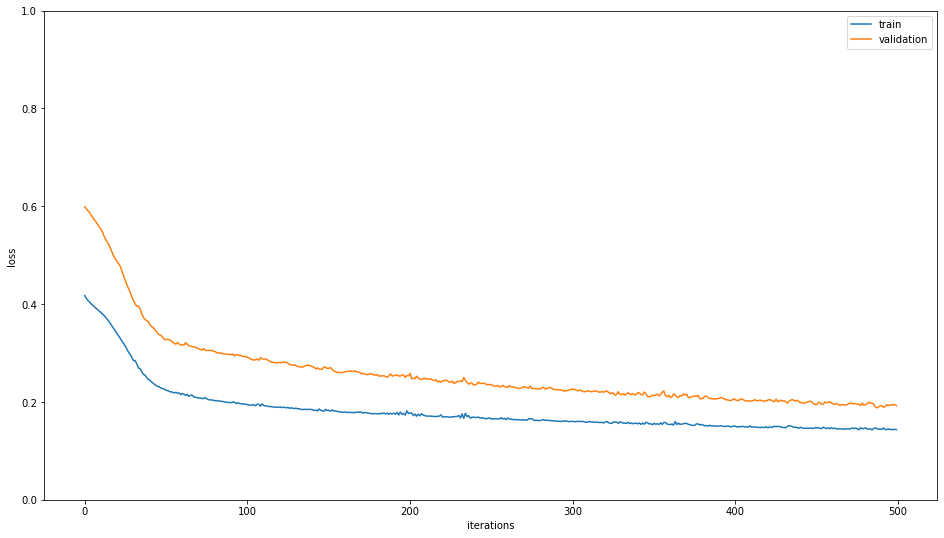

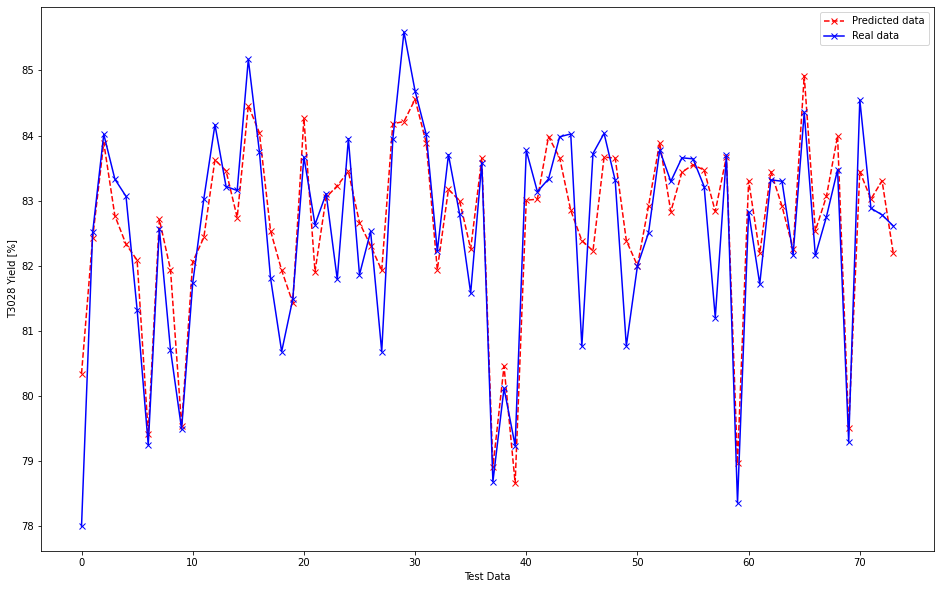

Mean absolute error:  0.5369387669743043
Root mean square error:  0.7162711082520987
Scatter index:  0.8679016884213544
pearson's correlation coefficient:  0.9020207305673831


In [7]:
plt.figure(figsize = (16, 9))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.ylim(0,1)
plt.legend()
plt.show()

y_prediction = model1.predict(X_test)
Y_test_prediction = scaler2.inverse_transform(y_prediction)

plt.figure(figsize=(16,10))
plt.plot(Y_test_prediction, '--rx',label = 'Predicted data')
plt.plot(Y_test,'-bx',label = 'Real data')
plt.xlabel('Test Data')
plt.ylabel('T3028 Yield [%]')
plt.legend()
plt.show()

mae = metrics.mean_absolute_error(Y_test, Y_test_prediction)
rmse = metrics.mean_squared_error(Y_test, Y_test_prediction, squared = False)

y_test_avg = Y_test.mean()
SI = (rmse/y_test_avg)*100   # scatter index

Y_test_prediction = np.array(Y_test_prediction, dtype=np.float)
Y_test_prediction = Y_test_prediction.flatten()

pear = stats.pearsonr(Y_test, Y_test_prediction)

print("Mean absolute error: ", mae)
print("Root mean square error: ", rmse)
print("Scatter index: ", SI)
print("pearson's correlation coefficient: ", pear[0])

In [ ]:
# saving model
model_json = model1.to_json()
with open(r"M:\TechlabsWS21\NNmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights(r"M:\TechlabsWS21\NNmodel.h5")
print("Saved model to disk")

#### feature selection

In [ ]:
shap.initjs()
explainer = shap.DeepExplainer(model1,X_train)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values[0], plot_type='bar', feature_names=X_nn.columns)

In [ ]:
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = X_nn.columns)

In [ ]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = X_nn.iloc[0,:], feature_names = X_nn.columns.tolist())

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], feature_names = X_nn.columns)

### using cross validation

In [ ]:
combIP_all = pd.read_excel(r'M:\TechlabsWS21\model_data\combT2955FINAL.xlsx')

combIP_temp = combIP_all.sample(frac=1).reset_index(drop=True)

Y_nn = combIP_temp['Yield T3028 [%]']
X_nn = combIP_temp.drop(['Yield T3028 [%]', , 'GRT13643L', 'GRTE7765', 'weitere_Verunreinigung'], axis=1)

Y_nn = np.ravel(Y_nn)
                                              

X_train1 = X_nn[0:60]
X_train2 = X_nn[60:120]
X_train3 = X_nn[120:180]
X_train4 = X_nn[180:240]
X_train5 = X_nn[240:300]
X_train6 = X_nn[300:]

Y_train1 = Y_nn[0:60]
Y_train2 = Y_nn[60:120]
Y_train3 = Y_nn[120:180]
Y_train4 = Y_nn[180:240]
Y_train5 = Y_nn[240:300]
Y_train6 = Y_nn[300:]

cv_loss=[]
cv_val_loss=[]
cv_Y_test_prediction=[]
cv_mae=[]
cv_mse=[]
cv_Y_test=[]
metric_list=[]

for i in range(6):
    print('\nFold: %s\n' %(i+1))
    if i==0:
        x_train = np.r_[X_train3, X_train4, X_train5, X_train6]
        y_train = np.r_[Y_train3, Y_train4, Y_train5, Y_train6]
        x_val = X_train1
        y_val = Y_train1
        x_test = X_train2
        y_test = Y_train2        
    elif i==1:
        x_train = np.r_[X_train1, X_train4, X_train5, X_train6]
        y_train = np.r_[Y_train1, Y_train4, Y_train5, Y_train6]
        x_val = X_train2
        y_val = Y_train2
        x_test = X_train3
        y_test = Y_train3
    elif i==2:
        x_train = np.r_[X_train1, X_train2, X_train5, X_train6]
        y_train = np.r_[Y_train1, Y_train2, Y_train5, Y_train6]
        x_val = X_train3
        y_val = Y_train3
        x_test = X_train4
        y_test = Y_train4
    elif i==3:
        x_train = np.r_[X_train1, X_train2, X_train3, X_train6]
        y_train = np.r_[Y_train1, Y_train2, Y_train3, Y_train6]
        x_val = X_train4
        y_val = Y_train4
        x_test = X_train5
        y_test = Y_train5
    elif i==4:
        x_train = np.r_[X_train1, X_train2, X_train3, X_train4]
        y_train = np.r_[Y_train1, Y_train2, Y_train3, Y_train4]
        x_val = X_train5
        y_val = Y_train5
        x_test = X_train6
        y_test = Y_train6
    elif i==5:
        x_train = np.r_[X_train2, X_train3, X_train4, X_train5]
        y_train = np.r_[Y_train2, Y_train3, Y_train4, Y_train5]
        x_val = X_train6
        y_val = Y_train6
        x_test = X_train1
        y_test = Y_train1
    
    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    x_val = scaler.transform(x_val)
    
    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    scaler2 = StandardScaler().fit(y_train)
    y_train = scaler2.transform(y_train) 
    y_val = scaler2.transform(y_val)
    
    model = Sequential()
    model.add(Dense(30, activation = 'relu', input_shape = (5,)))
    model.add(Dense(units = 30, activation = 'relu'))
    model.add(Dense(units = 20, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'linear'))    
    print(model.summary())

    model.compile(optimizer = "adam",
                 loss = tf.keras.losses.Huber(), 
                 #loss = 'mse',
                 metrics=['mse', 'mae'],
                 )
        
    history = model.fit(x_train, y_train, validation_data=(x_val,y_val),
                       batch_size = 50,
                       epochs = 200,
                       verbose = 1)
    
    y_prediction = model.predict(x_test)
    y_prediction = scaler2.inverse_transform(y_prediction)
    
    cv_loss.append(history.history['loss'])
    cv_val_loss.append(history.history['val_loss'])
    cv_Y_test_prediction.append(y_prediction)
    cv_Y_test.append(y_test)
    cv_mse.append(history.history['mse'])
    cv_mae.append(history.history['mae'])
    
    
    mae = metrics.mean_absolute_error(y_test, y_prediction)
    rmse = metrics.mean_squared_error(y_test, y_prediction, squared = False)
    y_test_avg = y_test.mean()
    SI = (rmse/y_test_avg)*100   # scatter index
    y_prediction = np.array(y_prediction, dtype=np.float)
    y_prediction = y_prediction.flatten()
    pear = stats.pearsonr(y_test, y_prediction)
    
    metric = {'MAE': mae, 'RMSE': rmse, 'Scatter Index':SI, 'Pearson Coefficient':pear[0]}
    metric_list.append(metric) 

In [ ]:
for i in range(6):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,9))
    ax1.plot(cv_loss[i], label = 'Training')
    ax1.plot(cv_val_loss[i], label = 'Validation')
    ax1.set_ylim(0,1)
    ax1.legend()
    ax2.plot(cv_Y_test_prediction[i],'--rx', label = 'Predicted data')
    ax2.plot(cv_Y_test[i],'-bx', label = 'Real data')
    ax2.legend()
    plt.show()


metric_data = pd.DataFrame(metric_list)
metric_data

# Predicting impurities

In [ ]:
combIP_all = pd.read_excel(r'M:\TechlabsWS21\model_data\combT2955FINAL.xlsx')
combIP_all

In [ ]:
#combIP_temp = combIP_all.sample(frac=1, random_state=1).reset_index(drop=True)

Y_nn = combIP_all[['GRT13643L', 'GRTE7765', 'weitere_Verunreinigung']].copy()
X_nn = combIP_all.drop(['GRT13643L', 'GRTE7765', 'weitere_Verunreinigung'], axis=1)

# normalisation is not needed for XGBoost since it is based on decision trees
# dividing data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_nn, Y_nn, 
                                                    test_size = 0.2, 
                                                    random_state = 3, 
                                                    shuffle = True)

In [ ]:
model = XGBRegressor(base_score=0.1, max_depth=50, num_parallel_tree=50)
multiOP = MultiOutputRegressor(model)
multiOP.fit(X_train, Y_train)

In [ ]:
X_test_prediction = multiOP.predict(X_test)

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(X_test_prediction[:,0], '--rx',label = 'Predicted data')
plt.plot(Y_test['GRT13643L'].values,'-bx',label = 'Real data')
plt.xlabel('Test Data')
plt.ylabel('GRT13643L')
plt.legend()
plt.show()


mae = metrics.mean_absolute_error(Y_test['GRT13643L'].values, X_test_prediction[:,0])
rmse = metrics.mean_squared_error(Y_test['GRT13643L'].values, X_test_prediction[:,0], squared = False)

y_test_avg = (Y_test['GRT13643L'].values).mean()
SI = (rmse/y_test_avg)*100   # scatter index

pear = stats.pearsonr(Y_test['GRT13643L'].values, X_test_prediction[:,0])  # pearson's correlation coefficient

print("Mean absolute error: ", mae)
print("Root mean square error: ", rmse)
print("Scatter index: ", SI)
print("pearson's correlation coefficient: ", pear[0])

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(X_test_prediction[:,1], '--rx',label = 'Predicted data')
plt.plot(Y_test['GRTE7765'].values,'-bx',label = 'Real data')
plt.xlabel('Test Data')
plt.ylabel('GRTE7765')
plt.legend()
plt.show()


mae = metrics.mean_absolute_error(Y_test['GRTE7765'].values, X_test_prediction[:,1])
rmse = metrics.mean_squared_error(Y_test['GRTE7765'].values, X_test_prediction[:,1], squared = False)

y_test_avg = (Y_test['GRTE7765'].values).mean()
SI = (rmse/y_test_avg)*100   # scatter index

pear = stats.pearsonr(Y_test['GRTE7765'].values, X_test_prediction[:,1])  # pearson's correlation coefficient

print("Mean absolute error: ", mae)
print("Root mean square error: ", rmse)
print("Scatter index: ", SI)
print("pearson's correlation coefficient: ", pear[0])

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(X_test_prediction[:,2], '--rx',label = 'Predicted data')
plt.plot(Y_test['weitere_Verunreinigung'].values,'-bx',label = 'Real data')
plt.xlabel('Test Data')
plt.ylabel('weitere_Verunreinigung')
plt.legend()
plt.show()


mae = metrics.mean_absolute_error(Y_test['weitere_Verunreinigung'].values, X_test_prediction[:,2])
rmse = metrics.mean_squared_error(Y_test['weitere_Verunreinigung'].values, X_test_prediction[:,2], squared = False)

y_test_avg = (Y_test['weitere_Verunreinigung'].values).mean()
SI = (rmse/y_test_avg)*100   # scatter index

pear = stats.pearsonr(Y_test['weitere_Verunreinigung'].values, X_test_prediction[:,2])  # pearson's correlation coefficient

print("Mean absolute error: ", mae)
print("Root mean square error: ", rmse)
print("Scatter index: ", SI)
print("pearson's correlation coefficient: ", pear[0])

In [ ]:
# # save model
# pickle.dump(multiOP, open(r'M:\TechlabsWS21\xgboostIMPURITY', 'wb'))